# 1.2.4: Bike Share (Interpretation)

<br>



---



*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>



---



In the previous chapter we began the process of interpretation by iterating our model in a way that created metrics that quantify the performance of a bike sharing system.  In this chapter we'll see how we can improve those metrics by changing the parameters of the system (such as the initial state).  In short, we'll use our simulation to explore the behavior of the system!

In [ ]:
# Import libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap01.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap01 import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py
Downloaded ModSimPy_Functions/chap01.py




---



## Comparing Systems with Different Parameters

If we know the actual values of parameters (like `p1`,`p2`, and the initial state), we can
use them to make specific predictions, like how many bikes will be at
Augustana after four hours.

<br>

But remember that prediction is only one goal of modeling; models like this are also used to
explain why systems behave as they do and to evaluate alternative
designs. For example, if we are considering adding more bikes, or another station, we could compare the effect of various "what if" scenarios.  In this case, we want to "sweep" through possible initial states in order to find the state that produces the best value for our metric.  In our case: how should we distribute our bikes every morning to minimize the number of unhappy customers?

<br>

To do these comparisons, though, we want to be able to run a lot of simulations as quickly as we can.  So first, we'll introduce a Python tool that will help us do that.

### Functions That Return Values

We have used several functions that return values.
For example, when you run `sqrt`, it returns a number you can assign to a variable.

In [ ]:
from numpy import sqrt

root_2 = sqrt(2)
root_2

1.4142135623730951

When we run `pd.Series`, it returns a new state object:

In [ ]:
bikeshare = pd.Series(dict(augie=10,moline=2),name='Number of Bikes')
bikeshare

augie     10
moline     2
Name: Number of Bikes, dtype: int64

Not all functions have return values. For example, when you run `change_func`,
it updates a state object, but it doesn't return a value.

To write functions that return values, we can use a `return` statement, like this:

In [ ]:
def add_five(x):
    return x + 5

`add_five` takes a parameter, `x`, which could be any number. It
computes `x + 5` and returns the result. So if we run it like this, the
result is `8`:

In [ ]:
x = add_five(3)
x

8

As a more useful example, here's a version of `run_simulation` that
creates a state object, runs a simulation, and then returns the
state object.  Notice that we have included the initial state as a parameter--this will come in handy later:

In [ ]:
def run_simulation(p1, p2, iAug, iMol, num_steps):
    state = pd.Series(dict(augie=iAug,moline=iMol,augie_empty=0,moline_empty=0,
                           clock=0),name="Number of Bikes")
    
    for i in range(num_steps):
        change_func(state, p1, p2)
        
    return state

We can call `run_simulation` like this:

In [ ]:
final_state = run_simulation(0.5, 0.4, 10, 2, 60)

The result is a `State` object that represents the final state of the system, including the metrics we'll use to evaluate the performance of the system:

In [ ]:
print(final_state.augie_empty, 
      final_state.moline_empty)

0 0


The simulation we just ran starts with `augie=10` and `moline=2`, and uses the values `p1=0.5`, `p2=0.4`, and `num_steps=60`. 
These five values are *parameters of the model*, which are quantities that determine the behavior of the system.  

<br>

The value of having `run_simulation` return the final state is that we can run the simulation in a single line and have a new object that contains all of the information about the final state (like the number of unhappy customers).  This is very efficient!

✅ ✅ Active reading: Add documentation to the `run_simulation` function above, including a docstring and line comments for each line.

### Sweeping Parameters

Now we want to run a set of simulations, each with a different initial state.  This will allow us to compare these situations, and determine which produces the fewest unhappy customers (our *metric*).  This process is called *sweeping* a parameter, in the sense that the value of the parameter "sweeps" through a range of possible values.

<br>

Now that we know about loops and arrays, we can use them like this:

In [ ]:

p1 = 0.5
p2 = 0.4
num_steps = 60

for i in range(13):
    final_state = run_simulation(p1, p2, i, 12-i, num_steps)
    print(i, final_state.augie_empty, final_state.moline_empty)

0 1 0
1 4 0
2 8 0
3 0 0
4 0 0
5 1 0
6 1 0
7 6 0
8 7 0
9 3 0
10 0 0
11 0 0
12 0 1


Each time through the loop, we run a simulation with a different value
of number of initial bikes at Augie and the same value of `p1` and `p2`. Then we print the initial number of bikes at Augie and the
number of unhappy customers at Augustana and Moline.

<br>

Run this cell multiple times, and make sure the results make sense to you.  Why are the results different each time?  Why does there tend to be more unhappy customers at Augie?  Why are there (generally) fewer unhappy customers as `i` gets larger?

✅ ✅Active Reading: Why do you think there are there fewer unhappy customers as `i` gets larger?



✅ ✅ Answer here


To save and plot the results, we can use another `Series`.  But in this case, the labels are the different parameter values (i.e. the initial bikes at Augie) rather than time values or state variable names, and the values in the `Series` will be the number of unhappy customers produced by each arrival rate.

In [ ]:
sweep = pd.Series([],name = "Unhappy Customers", dtype=object)
sweep.index.name = "Initial Bikes at Augie"

And add values like this:

In [ ]:
for i in range(13):
    final_state = run_simulation(p1, p2, i, 12-i, num_steps)
    sweep[i] = final_state.augie_empty + final_state.moline_empty

The result is a `Series` that maps from each value of `p1` to the
resulting number of unhappy customers.

We can display the results like this:

In [ ]:
pd.DataFrame(sweep)

,Unhappy Customers
Initial Bikes at Augie,
0,6
1,8
2,0
3,6
4,1
5,0
6,4
7,5
8,3


We can plot the results like this:

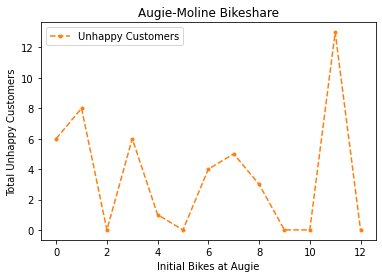

In [ ]:
sweep.plot(xlabel=sweep.index.name, 
           ylabel="Total Unhappy Customers",
            title='Augie-Moline Bikeshare',
            color='C1',legend=True,
            linestyle='--',marker='.');

The keyword argument `color='C1'` specifies the color of the line. The keyword arguments `marker` amd `linestyle` control the style of the plot.  Do a web search for 'matplotlib plot' to see available options.

<br>

Generally, when the number of initial bikes at Augie is high, there are fewer unhappy customers (since the tendency is for more bikes to go to Moline than vice versa).

<br>

The line is jagged because the simulation is based on random numbers. Sometime we get lucky and there are relatively few unhappy customers; other times are are unlucky and there are more.   How can we get more definitive answers?  We'll continue to iterate our model in the exercises to solve this problem.

<br>

---

## Summary and Exercises

This notebook focused on interpreting our model, which in this case meant trying to understand the relationship between our model parameters and our metric.  In the process, the notebook introduced:

* functions that return values, which we use to write a version of `run_simulation` that returns a `State` object with the final state of the system.

* parameter sweeps, which we used to explore the relationship between the initial state and the number of unhappy customers.

In the exercises, you'll have a chance to continue this interpretive work. 

### Incremental Development

When you start writing programs that are more than a few lines, you
might find yourself spending more time debugging. The more code you write before you start debugging, the harder it is to find the problem.

<br>

*Incremental development* is a way of programming that tries to
minimize the pain of debugging. You might not have noticed, but we've been doing incremental development in our notebook and exercises.  The fundamental steps are:

1.  Always start with a working program. If you have an example from a
    book, or a program you wrote that is similar to what you are working
    on, start with that. Otherwise, start with something you *know* is
    correct, like `x=5`. Run the program and confirm that it does what
    you expect.

2.  Make one small, testable change at a time. A "testable" change is
    one that displays something or has some other effect you can check.
    Ideally, you should know what the correct answer is, or be able to
    check it by performing another computation.

3.  Run the program and see if the change worked. If so, go back to
    Step 2. If not, you have to do some debugging, but if the
    change you made was small, it shouldn't take long to find the
    problem.

When this process works, your changes usually work the first time, or if they don't, the problem is obvious. In practice, there are two problems with incremental development:

-   Sometimes you have to write extra code to generate visible output
    that you can check. This extra code is called *scaffolding*
    because you use it to build the program and then remove it when you
    are done. That might seem like a waste, but time you spend on
    scaffolding is almost always time you save on debugging.

-   When you are getting started, it might not be obvious how to choose
    the steps that get from `x=5` to the program you are trying to
    write. You will see more examples of this process as we go along,
    and you will get better with experience.

The exercises below ask you to iterate the model we've created above.  If you find yourself writing more than a few lines of code before you
start testing, and you are spending a lot of time debugging, remember to take small steps and constantly check the results of your changes!

### Exercise 1

✅ ✅ Because our simulations are random, the results vary from one run to another, and the results of a parameter sweep tend to be noisy.  We can get a clearer picture of the relationship between a parameter and a metric by running multiple simulations with the same parameter and taking the average of the results.  

<br> This is not easy, so we are going to do some incremental coding here.  The first step is going to be to run a function that runs the same exact simulation multiple times and stores the results.

* In the first code cell below, write a function called `run_multiple_simulations` that takes as parameters `p1`, `p2`, `iAug` (initial bikes at Augie),`iMol`, `num_steps`, and `num_runs`.
`num_runs` specifies how many times it should call `run_simulation`.  After each run, it should store the total number of unhappy customers (at Augustana and Moline combined) in a `Series`.  At the end, it should return this `Series`.

* In the second cell, test your function with parameters and show the result `Series`:

```
p1 = 0.5
p2 = 0.4
iAug = 10
iMol = 2
num_steps = 60
num_runs = 20
```

* In the third cell, use the `mean` function that is built into `pd.Series` to compute the average number of unhappy customers (see "Under The Hood" section below to get an explanation of this function).

In [ ]:
## Define run_multiple_simulations in this cell.
## It should:
##      * Create an empty Series called local_results to store results
##      * Run run_simulation num_runs times
##            * For each run, store the number of unhappy customers in local_results
##      * Return local_results


    

In [ ]:
## Call run_multiple_simulations using the parameters listed above
## Return the function to a variable called 'results'
## Display 'results' in a DatFrame table



In [ ]:
## Print your mean value of 'results' using the function results.mean()


### Exercise 2

✅ ✅ So now we have a function that can run the same simulation multiple times.  The next incremental step is do this multiple times, using different initial states, and compare the metrics.  

* Use `iAug` values that range from 0 to 12.

* Store the results in yet another `Series`, with an index column of "Number of bikes initially at Augie" and a values column of "Average number of unhappy customers."

* Plot the average number of unhappy customers as a function of `iAug`.  Label the axes.

What value of `p1` minimizes the average number of unhappy customers?

In [ ]:
## Define your parameters
p1 = 0.5
p2 = 0.4
num_steps = 60
## Let's increase num_runs, since the computational time is short
num_runs = 100

## Create an empty series called 'unhappy' to store results


In [ ]:
## Write a loop that that includes run_multiple_simulations
## in order to populate 'unhappy'


In [ ]:
# Plot 'unhappy' with axis labels


### Exercise 3

✅ ✅ Take a moment and look at the results from exercise 2.  What is the ideal number of bikes to put at Augie in the morning? Look at the parameters, and explain in a couple sentences why that makes sense.

### Exercise 4

✅ ✅ Now go back and change some of the parameters (`num_steps`, `p2`, total number of bikes).  What do you expect to happen to the optimal initial state?  Rerun the experiments with changed paramters: does it change as you'd expect?  What happens if `p1`=`p2`?  What happens if the arrival rates both get higher?  What happens if there are more total bikes?  What happens if you increase `num_runs` to 500 or 1000 (the computation will take a bit longer, but not more than a minute or two)?

Write a paragraph explaining some of your thoughts and discoveries in a Markdown cell below this one.

## Under the Hood

`Series` provides a number of functions, which you can read about at <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html>.

They include `mean`, which computes the average of the values in the `Series`, so if you have a `Series` named `totals`, for example, you can compute the mean like this:

```
    totals.mean()
```

`Series` provides other statistical functions, like `std`, which computes the standard deviation of the values in the series.

In this chapter we use the keyword argument `color` to specify the color of a line plot.
You can read about the other available colors at <https://matplotlib.org/3.3.2/tutorials/colors/colors.html>.